<a href="https://colab.research.google.com/github/solomonmelwin/CODSOFT/blob/main/copy_of_untitled17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ Install Required Packages in Colab
!pip install tensorflow numpy matplotlib pillow scikit-learn albumentations



In [ ]:
import os
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV3Small, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
!unzip -q /content/bird-dataset-split.zip -d /content/bird-dataset-split


In [ ]:
import os

dataset_path = "/content/bird-dataset-split/train"  # Update if needed
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in os.listdir(dataset_path)}

for bird_class, count in class_counts.items():
    print(f"{bird_class}: {count} images")


Indian Spot-billed Duck: 700 images
greater flamingo: 700 images
Lesser Whistling Duck: 700 images
Fulvous Whistling Duck: 700 images
spot billed pelican: 700 images
Knob-billed Duck: 700 images
glossy ibis: 700 images
Graganey: 700 images
Common Pochard: 700 images
Eurasian Wigeon: 700 images
eurasian spoonbill: 700 images
Bar-headed Goose: 700 images
Northern Pintail: 700 images
black headed ibis: 700 images
Tufted Duck: 700 images
great white pelican: 700 images
asian openbill: 700 images
Northern Shoveler: 700 images
Green-winged Teal: 700 images
painted stork: 700 images


In [ ]:
# ✅ Define Dataset Paths
dataset_path = "/content/bird-dataset-split"
batch_size = 32
img_size = (224, 224)

# ✅ Load Dataset with Class Order Preserved
train_dataset = image_dataset_from_directory(f"{dataset_path}/train", shuffle=True, batch_size=batch_size, image_size=img_size)
val_dataset = image_dataset_from_directory(f"{dataset_path}/val", shuffle=True, batch_size=batch_size, image_size=img_size)
test_dataset = image_dataset_from_directory(f"{dataset_path}/test", shuffle=False, batch_size=batch_size, image_size=img_size)

# ✅ Save Class Names for Later Use
class_names = train_dataset.class_names
num_classes = len(class_names)
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("✅ Loaded Class Names:", class_names)


Found 14000 files belonging to 20 classes.
Found 3021 files belonging to 20 classes.
Found 2973 files belonging to 20 classes.
✅ Loaded Class Names: ['Bar-headed Goose', 'Common Pochard', 'Eurasian Wigeon', 'Fulvous Whistling Duck', 'Graganey', 'Green-winged Teal', 'Indian Spot-billed Duck', 'Knob-billed Duck', 'Lesser Whistling Duck', 'Northern Pintail', 'Northern Shoveler', 'Tufted Duck', 'asian openbill', 'black headed ibis', 'eurasian spoonbill', 'glossy ibis', 'great white pelican', 'greater flamingo', 'painted stork', 'spot billed pelican']


In [ ]:
# ✅ Apply Data Augmentation to Training Data
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.RandomShear(0.3)
])
train_dataset = train_dataset.map(lambda x, y: (augment_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# ✅ Compute Class Weights to Avoid Class Bias
label_list = []
for images, labels in train_dataset.unbatch():
    label_list.append(labels.numpy())

all_labels = np.array(label_list)
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = dict(enumerate(class_weights))

print("✅ Computed Class Weights:", class_weight_dict)


✅ Computed Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0), 9: np.float64(1.0), 10: np.float64(1.0), 11: np.float64(1.0), 12: np.float64(1.0), 13: np.float64(1.0), 14: np.float64(1.0), 15: np.float64(1.0), 16: np.float64(1.0), 17: np.float64(1.0), 18: np.float64(1.0), 19: np.float64(1.0)}


In [ ]:
# ✅ Load Pretrained Models
base_model_mobilenet = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_resnet = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# ✅ Unfreeze Some Layers for Fine-Tuning **EARLIER**
for layer in base_model_mobilenet.layers[-75:]:
    layer.trainable = True
for layer in base_model_resnet.layers[-75:]:
    layer.trainable = True

# ✅ Define Model Architecture
input_layer = Input(shape=(224, 224, 3))
x1 = base_model_mobilenet(input_layer, training=False)
x1 = GlobalAveragePooling2D()(x1)
x1 = BatchNormalization()(x1)  # ✅ Normalize features

x2 = base_model_resnet(input_layer, training=False)
x2 = GlobalAveragePooling2D()(x2)
x2 = BatchNormalization()(x2)  # ✅ Normalize features

x = Concatenate()([x1, x2])
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # ✅ Normalize fully connected layers
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=out)

import tensorflow as tf

# Function to convert integer labels to one-hot encoding
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=num_classes)  # Convert to one-hot
    return image, label

# Apply one-hot encoding to datasets
train_dataset = train_dataset.map(one_hot_encode)
val_dataset = val_dataset.map(one_hot_encode)
test_dataset = test_dataset.map(one_hot_encode)

# ✅ Now, your dataset outputs one-hot labels and works with CategoricalCrossentropy


# ✅ Use Label Smoothing to Reduce Overconfidence
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=loss_fn,
              metrics=["accuracy"])

print("✅ Model Built Successfully!")


✅ Model Built Successfully!


In [ ]:
# ✅ Train Model with Early Stopping & Class Weights
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weight_dict, callbacks=callbacks)

# ✅ Save Model Properly (Avoid Optimizer Mismatch Issue)
model.save("final_bird_model.keras", save_traces=False)



Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.2215 - loss: 3.3911

438/438 ━━━━━━━━━━━━━━━━━━━━ 448s 759ms/step - accuracy: 0.2217 - loss: 3.3900 - val_accuracy: 0.5174 - val_loss: 2.1932
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.4712 - loss: 2.2095

438/438 ━━━━━━━━━━━━━━━━━━━━ 284s 646ms/step - accuracy: 0.4712 - loss: 2.2092 - val_accuracy: 0.6031 - val_loss: 1.9263
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5775 - loss: 1.8382

438/438 ━━━━━━━━━━━━━━━━━━━━ 318s 635ms/step - accuracy: 0.5776 - loss: 1.8381 - val_accuracy: 0.7100 - val_loss: 1.4791
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.6701 - loss: 1.5984

438/438 ━━━━━━━━━━━━━━━━━━━━ 322s 636ms/step - accuracy: 0.6702 - loss: 1.5983 - val_accuracy: 0.7789 - val_loss: 1.3595
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 272s 619ms/step - accuracy: 0.7219 - loss: 1.4451 - val_accuracy: 0.7650 - val_loss: 1.3865
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.7766 - loss: 1.3342

438/438 ━━━━━━━━━━━━━━━━━━━━ 279s 634ms/step - accuracy: 0.7766 - loss: 1.3342 - val_accuracy: 0.8087 - val_loss: 1.2932
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.8087 - loss: 1.2340

438/438 ━━━━━━━━━━━━━━━━━━━━ 279s 634ms/step - accuracy: 0.8087 - loss: 1.2340 - val_accuracy: 0.8540 - val_loss: 1.1381
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 312s 611ms/step - accuracy: 0.8374 - loss: 1.1651 - val_accuracy: 0.8616 - val_loss: 1.1433
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.8582 - loss: 1.1069

438/438 ━━━━━━━━━━━━━━━━━━━━ 277s 631ms/step - accuracy: 0.8582 - loss: 1.1068 - val_accuracy: 0.9030 - val_loss: 1.0541
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 273s 622ms/step - accuracy: 0.8763 - loss: 1.0631 - val_accuracy: 0.8663 - val_loss: 1.1061
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.8881 - loss: 1.0183

438/438 ━━━━━━━━━━━━━━━━━━━━ 328s 633ms/step - accuracy: 0.8881 - loss: 1.0182 - val_accuracy: 0.9136 - val_loss: 1.0017
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 313s 614ms/step - accuracy: 0.8990 - loss: 0.9974 - val_accuracy: 0.9073 - val_loss: 1.0116
Epoch 13/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 392s 774ms/step - accuracy: 0.9152 - loss: 0.9578 - val_accuracy: 0.8977 - val_loss: 1.0103
Epoch 14/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 313s 617ms/step - accuracy: 0.9170 - loss: 0.9435 - val_accuracy: 0.8779 - val_loss: 1.0842
Epoch 15/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9178 - loss: 0.9350

438/438 ━━━━━━━━━━━━━━━━━━━━ 277s 630ms/step - accuracy: 0.9179 - loss: 0.9349 - val_accuracy: 0.9278 - val_loss: 0.9493
Epoch 16/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.9355 - loss: 0.8983

438/438 ━━━━━━━━━━━━━━━━━━━━ 347s 790ms/step - accuracy: 0.9355 - loss: 0.8982 - val_accuracy: 0.9255 - val_loss: 0.9214
Epoch 17/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9364 - loss: 0.8873

438/438 ━━━━━━━━━━━━━━━━━━━━ 273s 622ms/step - accuracy: 0.9364 - loss: 0.8873 - val_accuracy: 0.9421 - val_loss: 0.9074
Epoch 18/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9490 - loss: 0.8609

438/438 ━━━━━━━━━━━━━━━━━━━━ 277s 631ms/step - accuracy: 0.9490 - loss: 0.8609 - val_accuracy: 0.9441 - val_loss: 0.8917
Epoch 19/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 269s 611ms/step - accuracy: 0.9447 - loss: 0.8577 - val_accuracy: 0.9245 - val_loss: 0.9152
Epoch 20/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 332s 757ms/step - accuracy: 0.9593 - loss: 0.8315 - val_accuracy: 0.9265 - val_loss: 0.8922


ValueError: The following argument(s) are not supported: ['save_traces']

In [ ]:
model.save("final_bird_model.keras")  # ✅ Correct way to save


Saved artifact at '/tmp/tmpgqpfon6x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_3320')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  138260434115024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260434115600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260434115792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260434114640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260434111184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260434115408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260434119632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260434120208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260434120400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260434119248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13826043

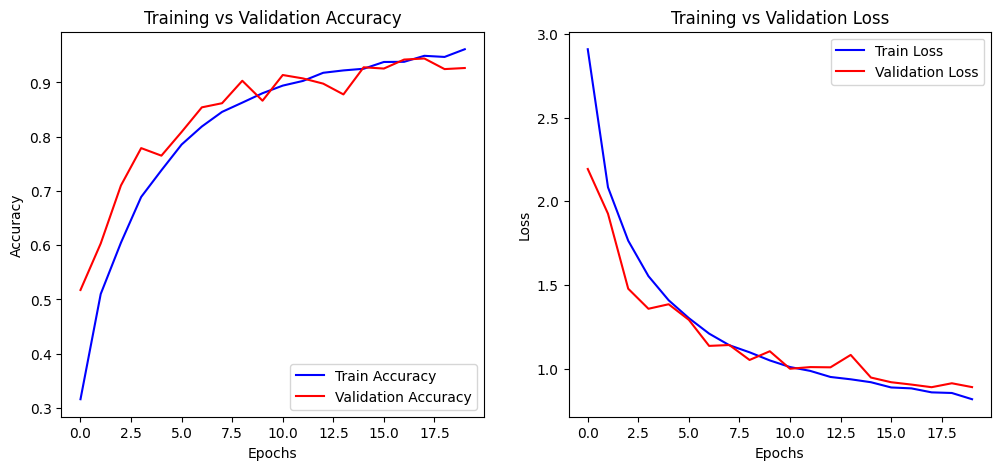

93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.9464 - loss: 0.8701
✅ Test Accuracy: 94.32%


In [ ]:
# ✅ Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# ✅ Save the TFLite model
with open("bird_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved as bird_model.tflite")

# ✅ Plot Training Curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy", color="blue")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training vs Validation Accuracy")

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss", color="blue")
    plt.plot(history.history['val_loss'], label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")

    plt.show()

# ✅ Run this after training
plot_training_curves(history)

# ✅ Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

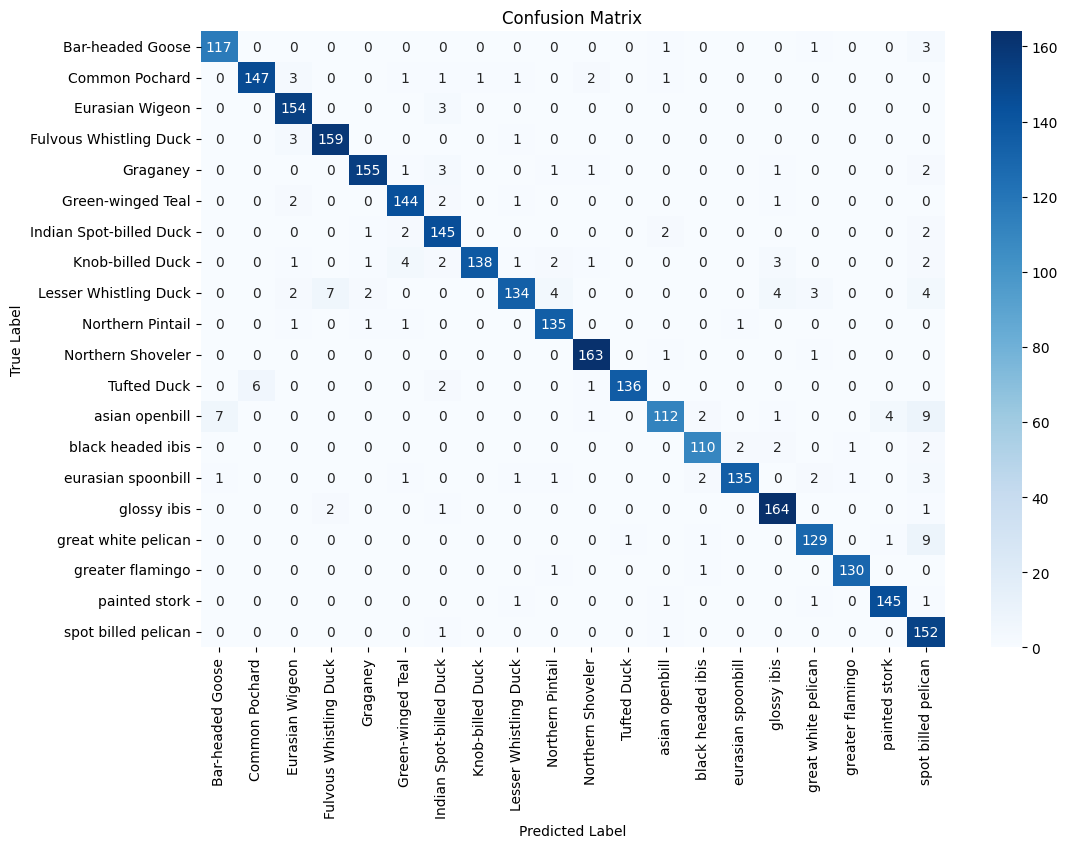

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ✅ Get True Labels & Predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert y_true to class indices
    y_pred.extend(np.argmax(preds, axis=1))  # Convert predictions to class indices

# ✅ Convert to NumPy Arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Now, `y_pred` matches `y_true`, so classification_report() works
print("✅ Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# ✅ Plot Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save("bird_classification_model.h5")



In [ ]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("/content/final_bird_model.keras")

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 362 variables whereas the saved optimizer has 722 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize to 224x224 (for MobileNetV3)
    img = preprocess_input(img)  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [ ]:
# Provide the path to your test bird image
test_image_path = "/content/download.jpeg"  # Change this to your test image

# Preprocess the image
input_img = load_and_preprocess_image(test_image_path)

# Predict the bird species
predictions = model.predict(input_img)

# Get the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Update this list with your actual class names (same as training classes)
class_labels = ['Bar-headed Goose', 'Common Pochard', 'Eurasian Wigeon', 'Fulvous Whistling Duck', 'Graganey', 'Green-winged Teal', 'Indian Spot-billed Duck', 'Knob-billed Duck', 'Lesser Whistling Duck', 'Northern Pintail', 'Northern Shoveler', 'Tufted Duck', 'asian openbill', 'black headed ibis', 'eurasian spoonbill', 'glossy ibis', 'great white pelican', 'greater flamingo', 'painted stork', 'spot billed pelican']

# Get the predicted class label
predicted_label = class_labels[predicted_class_index]

print(f"🦜 Predicted Bird Species: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
🦜 Predicted Bird Species: painted stork


In [ ]:
# prompt: download this as tflite /content/final_bird_model.keras for app development

import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model('/content/final_bird_model.keras')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('bird_model.tflite', 'wb') as f:
  f.write(tflite_model)

from google.colab import files
files.download('bird_model.tflite')


Saved artifact at '/tmp/tmpdo3r49ex'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_9')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  138260439162448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439163024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439163216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439162064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439155536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439162832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439164752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439165328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439165520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439164368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260439158

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>